In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.api as sm
from scipy.stats import chi2

import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) # Kiitos, Elina!

## Tavoite

Tavoite on mallintaa, voidaanko asiakkaalle myöntää laina vai ei.

Kirjaa ylös mahdolliset johtopäätökset mallin toimivuudesta ja yleistettävyydestä 

In [42]:
df = pd.read_csv("Loan_Data.csv")
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [43]:
df.shape

(614, 13)

In [44]:
# Ei duplkaatteja
duplikaatteja = df.duplicated()
duplikaatteja.value_counts()

False    614
Name: count, dtype: int64

In [45]:
# Puuttuvat arvot
puuttuvia_arvoja = df.isnull().any(axis=1).sum()
print(f"Rivejä, joilla puuttuvia arvoja: {puuttuvia_arvoja}")

Rivejä, joilla puuttuvia arvoja: 134


In [46]:
# Antaa kentät, joilla puuttuvia arvoja
display(df.isnull().sum()) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [47]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [48]:
df["Self_Employed"].value_counts()

Self_Employed
No     500
Yes     82
Name: count, dtype: int64

In [49]:
# df["Gender"].unique() -> for one column, following for all columns
selected_columns = df.iloc[:, 1:6]
unique_values = {col: selected_columns[col].unique() for col in selected_columns.columns}

for column, values in unique_values.items():
    print(f"Unique values in '{column}': {values}")

Unique values in 'Gender': ['Male' 'Female' nan]
Unique values in 'Married': ['No' 'Yes' nan]
Unique values in 'Dependents': ['0' '1' '2' '3+' nan]
Unique values in 'Education': ['Graduate' 'Not Graduate']
Unique values in 'Self_Employed': ['No' 'Yes' nan]


In [50]:
selected_columns = df.iloc[:, 9:13]
unique_values = {col: selected_columns[col].unique() for col in selected_columns.columns}

for column, values in unique_values.items():
    print(f"Unique values in '{column}': {values}")

Unique values in 'Loan_Amount_Term': [360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]
Unique values in 'Credit_History': [ 1.  0. nan]
Unique values in 'Property_Area': ['Urban' 'Rural' 'Semiurban']
Unique values in 'Loan_Status': ['Y' 'N']


In [51]:
# muutetaan vastemuuttujat numeeriksi, 0 = normaali
df['Gender'].replace(['Male', 'Female'], [1,2], inplace=True)
df['Gender'].fillna(0, inplace=True) # sukupuoli 0, jos puuttuu
df['Married'].replace(['No', 'Yes'], [0,1], inplace=True)
df['Married'].fillna(2, inplace=True) # avioliitto 2, jos puuttuu
df['Education'].replace(['Not Graduate', 'Graduate'], [0,1], inplace=True)
df['Education'].fillna(2, inplace=True) # koulutus 2, jos puuttuu
df['Self_Employed'].replace(['No', 'Yes'], [0,1], inplace=True)
df['Self_Employed'].fillna(2, inplace=True)
df['Dependents'].replace(['0', '1,', '2', '3+'], [0,1,2,3], inplace=True) # Eniten 0-arvoja
df["Dependents"].fillna(0, inplace=True)
df['Credit_History'].fillna(2, inplace=True) # credit history 2, jos puuttuu
df['Loan_Status'].replace(['N', 'Y'], [0,1], inplace=True)

In [52]:
df["Dependents"] = pd.to_numeric(df["Dependents"])  # integer

In [53]:
dummies= pd.get_dummies(df['Property_Area'])

In [54]:
df = pd.concat([df, dummies], axis=1)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    float64
 2   Married            614 non-null    float64
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    int64  
 5   Self_Employed      614 non-null    float64
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
 13  Rural              614 non-null    bool   
 14  Semiurban          614 non-null    bool   
 15  Urban              614 non-null    bool   
dtypes: bool(3), float64(7), in

In [56]:
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean()) 

In [57]:
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean()) 

In [58]:
df.drop("Loan_ID", axis=1, inplace=True)
df.drop("Property_Area", axis=1, inplace=True)
df.drop(["Semiurban","Urban", "Rural"], axis=1, inplace=True)

# df.drop("Semiurban", axis=1, inplace=True)
# df.drop("Rural", axis=1, inplace=True)
# df.drop("Urban", axis=1, inplace=True)

In [59]:
# Antaa kentät, joilla puuttuvien arvojen määrät
display(df.isnull().sum()) 

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Loan_Status          0
dtype: int64

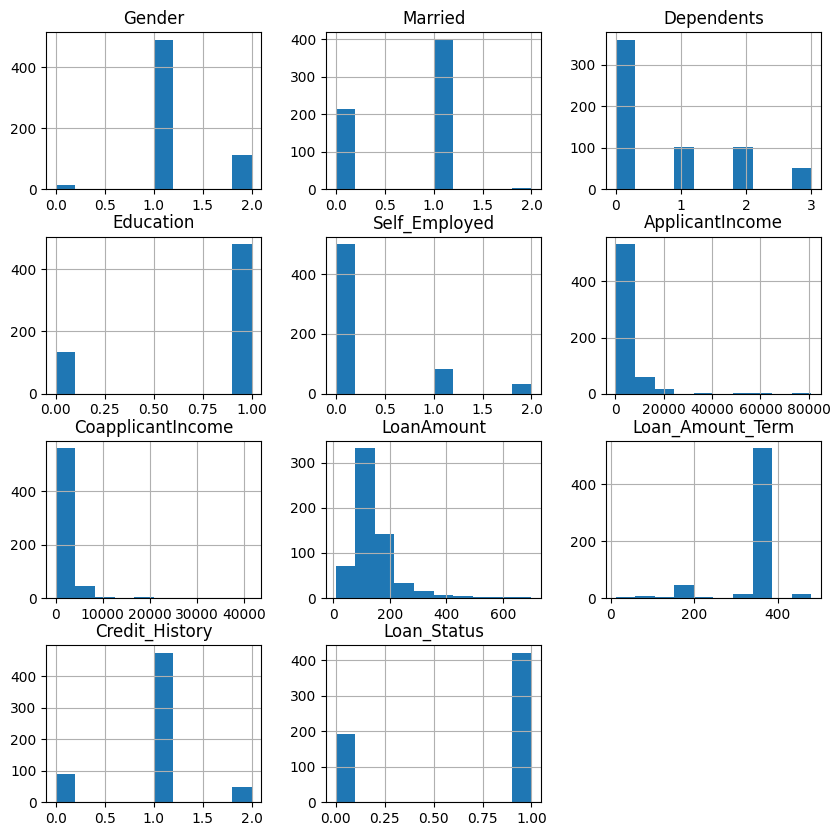

In [60]:
df.hist(figsize=(10,10))
plt.show()

In [61]:
korr = df.corr()
# print(korr)

Ei kolineaarisuutta

<Axes: >

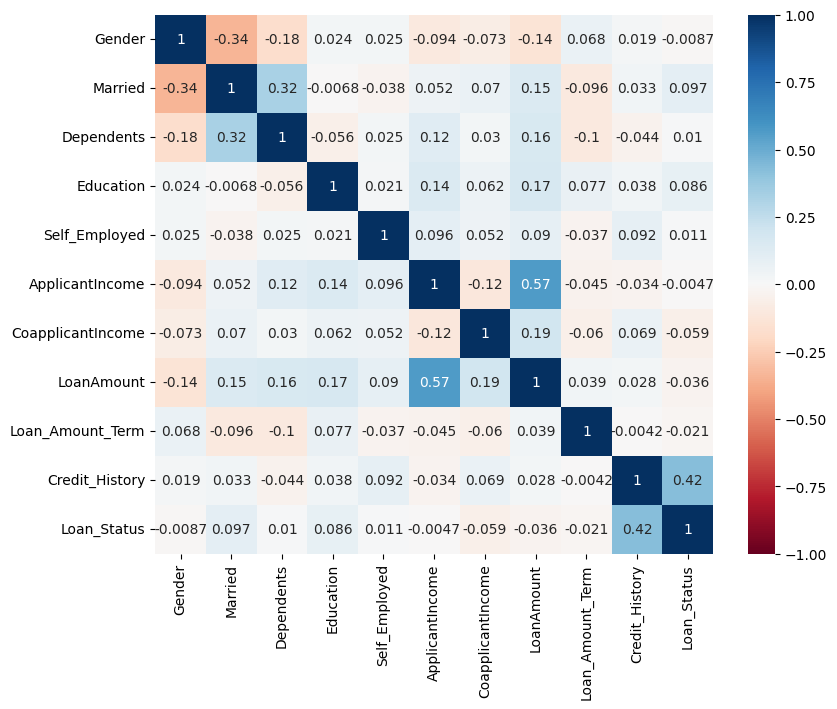

In [62]:
plt.figure(figsize=(9,7))
sns.heatmap(korr,vmin=-1.0,vmax=1.0, cmap='RdBu', annot=True)

In [63]:
df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,1.161238,0.657980,0.744300,0.781759,0.237785,5403.459283,1621.245798,146.412162,342.000000,0.936482,0.687296
std,0.421752,0.484971,1.009623,0.413389,0.534737,6109.041673,2926.248369,84.037468,64.372489,0.471924,0.463973
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2877.500000,0.000000,100.250000,360.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3812.500000,1188.500000,129.000000,360.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,5795.000000,2297.250000,164.750000,360.000000,1.000000,1.000000
max,2.000000,2.000000,3.000000,1.000000,2.000000,81000.000000,41667.000000,700.000000,480.000000,2.000000,1.000000


## Mallinnus - logistinen regressio

Tehdään ensin kaikilla muuttujilla

In [64]:
X = df.loc[:,['Gender', 'Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']]
Y = df.iloc[:,10] # vastemuuttuja on positio 10 eli Loan_Status

In [65]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

## Tehdään skaalaus. Muuten max_iter ei toiminut.

In [66]:
# Skaalataan, jotta saadaan malli toimimaan, muutoin herja, joka ei poistunut millään määrämuutoksella 
# ConvergenceWarning: lbfgs failed to converge (status=1):
# STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
# Increase the number of iterations (max_iter) or scale the data as shown in:
# Skaalauksen valmistelu
scaler = StandardScaler().fit(x_train) 
scaler
print('mean', scaler.mean_)
print('scale', scaler.scale_)

mean [1.16496945e+00 6.37474542e-01 7.29124236e-01 7.78004073e-01
 2.34215886e-01 5.50264562e+03 1.67648864e+03 1.48646832e+02
 3.40325866e+02 9.38900204e-01]
scale [4.32011999e-01 4.84947492e-01 1.00808698e+00 4.15588420e-01
 5.26420439e-01 5.92690661e+03 3.17440396e+03 8.61880423e+01
 6.68070124e+01 4.69360630e-01]


In [67]:
# x_training arvojen muokkaus skaalauksen mukaisesti > x_scaled
x_train_scaled = scaler.transform(x_train)
print('scaled', x_train_scaled)

print('mean', x_train_scaled.mean(axis=0))
print('std', x_train_scaled.std(axis=0))

scaled [[-0.38186312  0.7475561  -0.72327513 ...  1.349992    0.29449206
   2.26073456]
 [-0.38186312  0.7475561  -0.72327513 ... -0.20474803  0.29449206
   0.13017665]
 [-0.38186312  0.7475561   1.26068067 ...  0.71185244  0.29449206
   0.13017665]
 ...
 [ 1.9328874  -1.31452281 -0.72327513 ... -1.37660433  0.29449206
   0.13017665]
 [ 1.9328874   2.80963502 -0.72327513 ... -0.02592784 -1.50172657
   0.13017665]
 [-0.38186312  0.7475561  -0.72327513 ... -0.02592784  0.29449206
   0.13017665]]
mean [-1.77273900e-16 -8.68280329e-17 -5.42675206e-17 -1.04917206e-16
  7.23566941e-18 -7.23566941e-18 -3.25605123e-17  9.40637023e-17
 -6.69299420e-17 -1.10343958e-16]
std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [68]:
# Mallin rakentaminen ja sovittaminen, käytetään skaalattua x_trainia
reg = LogisticRegression(random_state=42)
reg.fit(x_train_scaled,y_train)

print("Coefficients: ",reg.coef_)
print("Intercept: ", reg.intercept_)

Coefficients:  [[ 0.04542503  0.28547572  0.10394199  0.1862688   0.00850712 -0.00276811
  -0.21447629 -0.21112766  0.02717327  1.20207513]]
Intercept:  [1.01971499]


In [69]:
# TÄMÄ EI TOIMINUT
# reg = LogisticRegression(max_iter=2000)
# reg.fit(X_train,Y_train)

# print("Coefficients: ",reg.coef_)
# print("Intercept: ",reg.intercept_)

In [70]:
### SKAALAUKSEN OLISI VOINUT TEhDÄ MYÖS NÄIN

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Split the data
# X = df.loc[:, ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
#                'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
#                'Loan_Amount_Term', 'Credit_History']]
# Y = df.iloc[:, 10]  # Target variable Loan_Status

# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# # Scale the data
# scaler = StandardScaler().fit(x_train)
# x_train_scaled = scaler.transform(x_train)
# x_test_scaled = scaler.transform(x_test)


In [71]:
# x_testin skaalaus
scaler2 = StandardScaler().fit(x_test)
scaler2
# print('mean', scaler2.mean_)
# print('scale', scaler2.scale_)

StandardScaler()

In [72]:
# x_testin muokkaus skaalatuksi
x_test_scaled = scaler2.transform(x_test)
# print('scaled', x_test_scaled)

# print('mean', x_test_scaled.mean(axis=0))
# print('std', x_test_scaled.std(axis=0))

In [73]:
p_pred = reg.predict_proba(x_test_scaled) # todennäköisyys joka tilastoriville
# print("p_pred :", p_pred, sep="\n", end="\b\n")

In [74]:
y_pred = reg.predict(x_test_scaled) #ennustetulos, joka todennäköisyyden perusteella joka tilastoriville

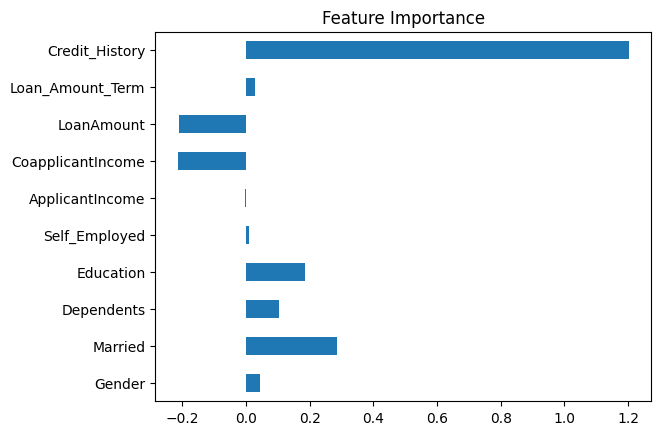

In [79]:
# tutkitaan eri selittävien muuttujien vaikutusta selitettävään muuttujaan
# model.coef_ palauttaa listan kertoimista kullekin selittävälle muuttujalle
# pos. kerroin: suurempi arvo kasvattaa todennäköisyyttä positiiviseen luokkaan (neg. kerroin päinvastoin)
feature_importance = pd.Series(reg.coef_[0], index=X.columns) # index=X.columns hakee sarjan indekseiksi selittävien muuttujien nimet 
feature_importance.plot(kind='barh') # kind='barh' -> vaakasuora pylväskaavio (horizontal bar)
plt.title('Feature Importance')
plt.show()

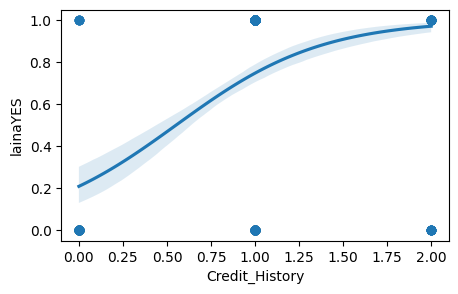

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,3))
sns.regplot(x=df["Credit_History"], y=df["Loan_Status"].eq(1).rename("lainaYES"), logistic=True)
plt.show()

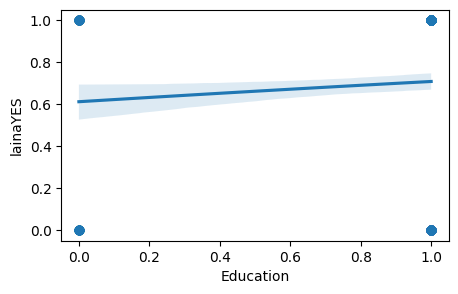

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,3))
sns.regplot(x=df["Education"], y=df["Loan_Status"].eq(1).rename("lainaYES"), logistic=True)
plt.show()

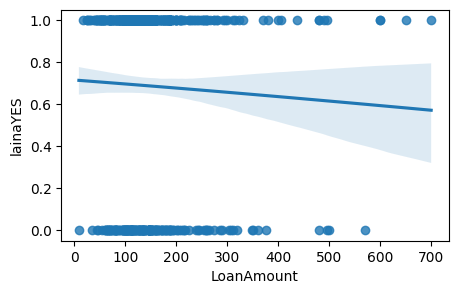

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,3))
sns.regplot(x=df["LoanAmount"], y=df["Loan_Status"].eq(1).rename("lainaYES"), logistic=True)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,3))
sns.regplot(x=df["Married"], y=df["Loan_Status"].eq(1).rename("lainaYES"), logistic=True)
plt.show()

### Mallin sopivuus

Tämä seuraava testi sopii yksittäisten selittävien muuttujien poistoon.

Seuraavat kokeiluja, joista ei nyt tässä varsainaisesti mitään hyötyä

In [ ]:
# Fit the full model
full_model = LogisticRegression(max_iter=1000)
full_model.fit(x_train_scaled, y_train)

# Log-likelihood of the full model
ll_full = full_model.score(x_train_scaled, y_train)

In [ ]:
# Remove 'CoapplicantIncome' for the reduced model
X_reduced = X.drop(columns=['Credit_History'])

# Split and scale the reduced dataset
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)
scaler_red = StandardScaler().fit(x_train_red)
x_train_red_scaled = scaler_red.transform(x_train_red)

# Fit the reduced model
reduced_model = LogisticRegression(max_iter=1000)
reduced_model.fit(x_train_red_scaled, y_train_red)

# Log-likelihood of the reduced model
ll_reduced = reduced_model.score(x_train_red_scaled, y_train_red)


In [ ]:

# Full model
x_train_scaled_sm = sm.add_constant(x_train_scaled)  # Add constant for intercept
full_model_sm = sm.Logit(y_train, x_train_scaled_sm).fit()
ll_full = full_model_sm.llf  # Log-likelihood of the full model

# Reduced model
x_train_red_scaled_sm = sm.add_constant(x_train_red_scaled)  # Add constant for intercept
reduced_model_sm = sm.Logit(y_train_red, x_train_red_scaled_sm).fit()
ll_reduced = reduced_model_sm.llf  # Log-likelihood of the reduced model


Optimization terminated successfully.
         Current function value: 0.493273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599456
         Iterations 5


1) F-statistic: 3.7856314128553294, p-value: 0.05227774608802538  (poistettiin kumppanin tulot)

2) F-statistic: 102.901363843094, p-value: 1.1102230246251565e-16 (poistettiin credit history)

Tulkinta ylläolevalle: Suuri F-luku kertoo siitä, että ero mallien välillä on suuri.

Pieni, että poistolla ei vaikutusta.

Lisäksi pieni p-arvo siitä, että ero on merkittävä ja toisaalta p-value, joka yli 0,05 siitä, että ero ei ole merkittävä.

### Fisher F-suhde, eli nollasumma hypoteesin testaaminen

Fisherin idea, paljonko selittää pelkkä vakiotermi ja paljonko muut eli onko mallilla arvoa.

### Fisherin testin mukaan malli on kannattanut tehdä

In [ ]:

# Add a constant to X for the intercept
X_with_const = sm.add_constant(x_test_scaled)
model_sm = sm.Logit(y_test, X_with_const).fit(disp=0)

# Get the deviance for null and fitted model
null_deviance = -2 * model_sm.llnull
residual_deviance = -2 * model_sm.llf
df = model_sm.df_model  # degrees of freedom

# Chi-square statistic
chi2_stat = null_deviance - residual_deviance
p_value = chi2.sf(chi2_stat, df)

print("Chi-squared statistic:", chi2_stat)
# print("Degrees of freedom:", df) - selittävien muuttujien määrä
print("p-value:", p_value)


Chi-squared statistic: 29.92536352848998
p-value: 0.0008810536975207473


In [ ]:
# Assuming X is your features and y is your binary target variable
# Step 1: Add a constant (intercept) to X
X_with_const = sm.add_constant(x_test_scaled)

# Step 2: Fit the logistic regression model with statsmodels
logit_model = sm.Logit(y_test, X_with_const).fit(disp=0)

# Step 3: Get the null deviance and residual deviance
# Null deviance is the deviance of the intercept-only model
null_deviance = -2 * logit_model.llnull  # Deviance of the null model
# Residual deviance is the deviance of the full model with predictors
residual_deviance = -2 * logit_model.llf  # Deviance of the fitted model

# Degrees of freedom for the Chi-squared test
df = logit_model.df_model

# Chi-square test statistic
chi2_stat = null_deviance - residual_deviance

# Calculate the p-value
p_value = chi2.sf(chi2_stat, df)

# Print results
print("Chi-squared statistic:", chi2_stat) # Mitä suurempi sen parempi
print("Degrees of freedom:", df) # selittävien muuttujien määrä
print("p-value:", p_value) # Hyvä, koska todella pieni luku

# Interpretation:
# A low p-value (e.g., < 0.05) indicates that the model with predictors
# provides a significantly better fit than the null model with only an intercept.

Chi-squared statistic: 29.92536352848998
Degrees of freedom: 10.0
p-value: 0.0008810536975207473


Goodness of fitin vois myös tehdä... mutta jätin nyt väliin

### Ennustetarkkuus

Malli ennustaa erittäin hyvin kenelle ei kannata myöntää lainaa. Sen sijaan malli ennustaa huonosti, 
kenelle kannattaisi myöntää laina. 24% ihmisistä saisi lainan, vaikka ei pitäisi, jos tätä mallia noudatettaisiin. 
Käytännön sovellus olisi käyttää mallia poistamaan ihmiset, joille ei missään tapauksessa kannata myöntää lainaa ja sen jälkeen tarkastelu kuten ennenkin.
Muita tutkittavia polkua: uutta dataa, toinen malli ennustamaan loppuja?

In [ ]:
print(classification_report(y_test, y_pred, target_names=["lainaNO", "lainaYES"]))

# Accuracy ei toimi tässä johtuen siitä, että malli on epätasapainoinen

              precision    recall  f1-score   support

     lainaNO       0.95      0.42      0.58        43
    lainaYES       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",cm)

Confusion matrix:
 [[18 25]
 [ 1 79]]


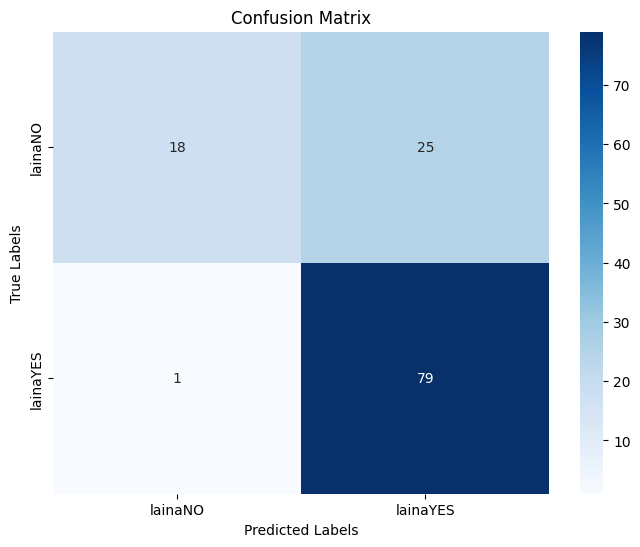

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['lainaNO', 'lainaYES'], yticklabels=['lainaNO', 'lainaYES'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

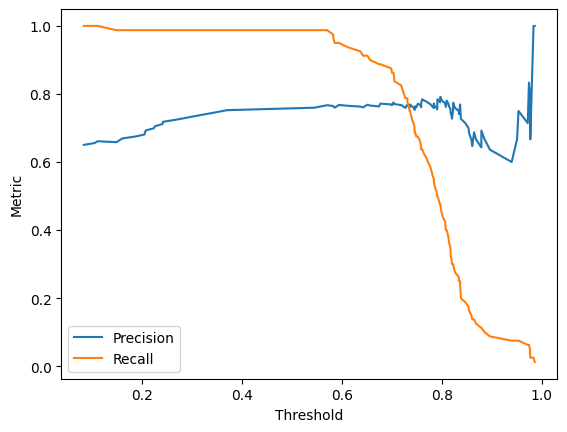

In [77]:
from sklearn.metrics import precision_recall_curve

y_pred_prob_orig = reg.predict_proba(x_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_orig)

# Plot precision-recall curve
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.legend()
plt.show()


Mallin muuttujien kertoimien, oddsration, p-arvojen ja luottamusvälin laskeminen.

Kerroin on muuttajan painoarvo ja Oddsratio kertoo, miten muuttuja vaikuttaa.

-	ykköstä pienemmät Exp(b)-kertoimet tarkoittavat, että kyseisen muuttujan arvon kasvattaminen pienentää riskiä
-	ykköstä suuremmat Exp(b)-kertoimet tarkoittavat, että kyseisen muuttujan arvon kasvattaminen kasvattaa riskiä



In [ ]:
original_column_names = ['Gender', 'Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History'] # Replace with your actual feature names

# Convert x_test_scaled back to a DataFrame with the original column names
X_test_scaled_df = pd.DataFrame(x_test_scaled, columns=original_column_names)


In [ ]:
# Assuming X is your feature matrix and y is your binary target variable
# Add a constant to the features for the intercept term
X_with_const = sm.add_constant(X_test_scaled_df)

y_test = y_test.reset_index(drop=True)
X_with_const = X_with_const.reset_index(drop=True)

# Fit the logistic regression model
logit_model = sm.Logit(y_test, X_with_const).fit(disp=0)


# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_test, X_with_const).fit(disp=0)

# Get the coefficients
coefficients = logit_model.params

# Calculate Exp(b) (odds ratios) for each coefficient
odds_ratios = np.exp(coefficients)

# Calculates P-values
p_values = logit_model.pvalues

# Luottamusväli
conf_intervals = logit_model.conf_int()
conf_intervals.columns = ['CI Lower', 'CI Upper']  # Rename columns for clarity

# "Variable": coefficients.index,

# Display the results in a table
results = pd.DataFrame({
    
    "Coefficient (b)": coefficients.values,
    "Exp(b) (Odds Ratio)": odds_ratios.values,
    "P-values:": p_values.values,
    "CI Lower": np.exp(conf_intervals['CI Lower']),  # Lower bound of CI for odds ratios
    "CI Upper": np.exp(conf_intervals['CI Upper'])   # Upper bound of CI for odds ratios
})

print(results)

                   Coefficient (b)  Exp(b) (Odds Ratio)  P-values:  CI Lower  \
const                     0.772784             2.165787   0.000550  1.397111   
Gender                   -0.225370             0.798221   0.359810  0.492757   
Married                   0.256316             1.292162   0.341264  0.762184   
Dependents               -0.158143             0.853728   0.512321  0.531957   
Education                 0.336314             1.399778   0.115545  0.920779   
Self_Employed            -0.350029             0.704668   0.135945  0.444799   
ApplicantIncome           0.266508             1.305399   0.544292  0.551577   
CoapplicantIncome        -0.248810             0.779728   0.335886  0.469748   
LoanAmount               -0.288525             0.749368   0.429082  0.366538   
Loan_Amount_Term         -0.331807             0.717626   0.277744  0.394172   
Credit_History            1.073012             2.924175   0.000069  1.724053   

                   CI Upper  
const    

### Yritys parantaa mallin tasapainoa eri tekniikoilla
Class weight ei toimi laisinkaan.

Snote toimii paremmin, mutta ei niin hyvin, että toimisi paremmin kuin alkuperäinen.


In [ ]:
# # Train logistic regression with class weights - ei toiminut
# model = LogisticRegression(class_weight='balanced', random_state=42)
# model.fit(x_train_scaled, y_train)

# # Predict and evaluate
# y_predw = model.predict(x_test_scaled)
# print(classification_report(y_test, y_predw))


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionen
from sklearn.metrics import classification_report

# Split data
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Train logistic regression
model = LogisticRegression(max_iter=5000,random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65        38
           1       0.86      0.79      0.82        85

    accuracy                           0.76       123
   macro avg       0.73      0.75      0.74       123
weighted avg       0.78      0.76      0.77       123



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",cm)

Confusion matrix:
 [[ 6 32]
 [13 72]]


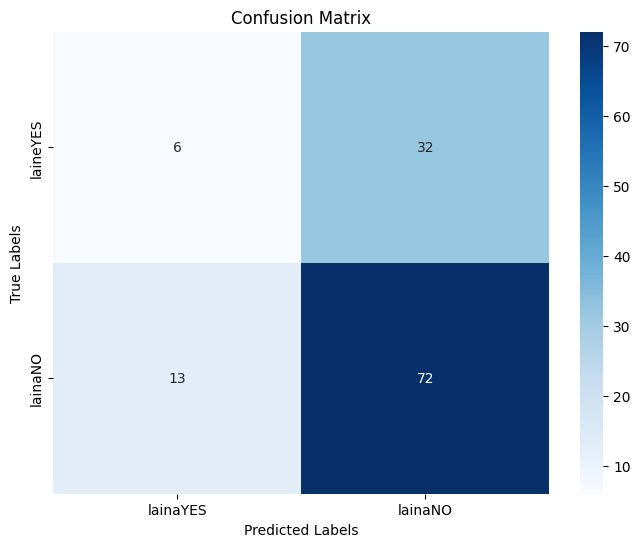

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['lainaYES', 'lainaNO'], yticklabels=['laineYES', 'lainaNO'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Assuming X is your features and y is your binary target variable
# Step 1: Add a constant (intercept) to X
X_with_const = sm.add_constant(x_test)

# Step 2: Fit the logistic regression model with statsmodels
logit_model = sm.Logit(y_test, X_with_const).fit(disp=0)

# Step 3: Get the null deviance and residual deviance
# Null deviance is the deviance of the intercept-only model
null_deviance = -2 * logit_model.llnull  # Deviance of the null model
# Residual deviance is the deviance of the full model with predictors
residual_deviance = -2 * logit_model.llf  # Deviance of the fitted model

# Degrees of freedom for the Chi-squared test
df = logit_model.df_model

# Chi-square test statistic
chi2_stat = null_deviance - residual_deviance

# Calculate the p-value
p_value = chi2.sf(chi2_stat, df)

# Print results
print("Chi-squared statistic:", chi2_stat) # Tää on se GOF, hyvä, koska suuri luku
print("Degrees of freedom:", df) # selittävien muuttujien määrä
print("p-value:", p_value) # Hyvä, koska tdeolla pieni luku, ilmeisesti....

# Interpretation:
# A low p-value (e.g., < 0.05) indicates that the model with predictors
# provides a significantly better fit than the null model with only an intercept.

Chi-squared statistic: 66.2169346869185
Degrees of freedom: 10.0
p-value: 2.369937708576483e-10


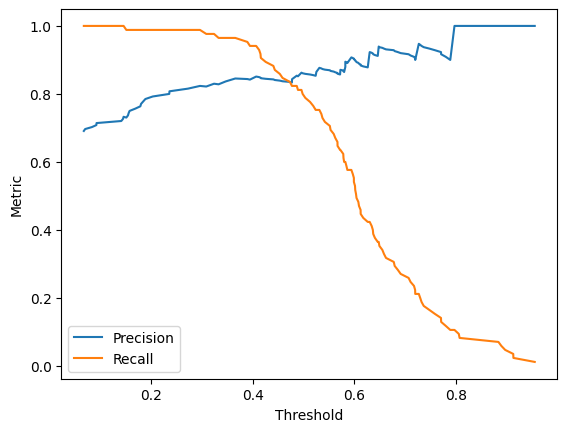

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred_prob = model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot precision-recall curve
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.legend()
plt.show()
